# Bayesian online changepoint detection

In [410]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial

In [349]:
%config InlineBackend.figure_format = "retina"

%load_ext autoreload
%autoreload 2

In [5]:
target_M = jnp.arange(5 ** 2).reshape(5, 5)

In [125]:
T = 7
n_elements =  T * (T + 1) // 2
n_elements

28

In [126]:
target_array = jnp.arange(1, n_elements + 1)

In [127]:
M = jnp.zeros((T, T))
count = 1
for t in range(T):
    for j in range(t+1):
        M = M.at[t, j].set(count)
        count += 1

In [351]:
@partial(jax.jit, static_argnames=("T",))
def slice_tril_array(t, tril_array, T):
    """
    tril_array: represent a lower-triangular matrix in the form of an aray
    """
    num_elements = T * (T + 1) // 2
    
    mask = jnp.arange(T)
    mask = mask <= t
    
    t = t.astype(int)
    s_init = t * (t + 1) // 2
    s_end = s_init + num_elements
    
    vslice = jnp.roll(tril_array, -s_init)
    vslice = jax.lax.slice_in_dim(vslice, 0, T)
    
    return vslice * mask

@jax.jit
def insert_in_tril_array(t, x, tril_array):
    start_from = t * (t + 1) // 2
    return jax.lax.dynamic_update_slice(tril_array, x, (start_from,))

In [352]:
slice_tril_array(5, target_array, T)

Array([16, 17, 18, 19, 20, 21,  0], dtype=int32)

In [353]:
new_vals = insert_in_tril_array(6, jnp.ones(T) * -1.0, target_array.astype(float))
new_vals

Array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., -1., -1., -1., -1., -1.,
       -1., -1.], dtype=float32)

## Step-by-step

In [889]:
import bocd

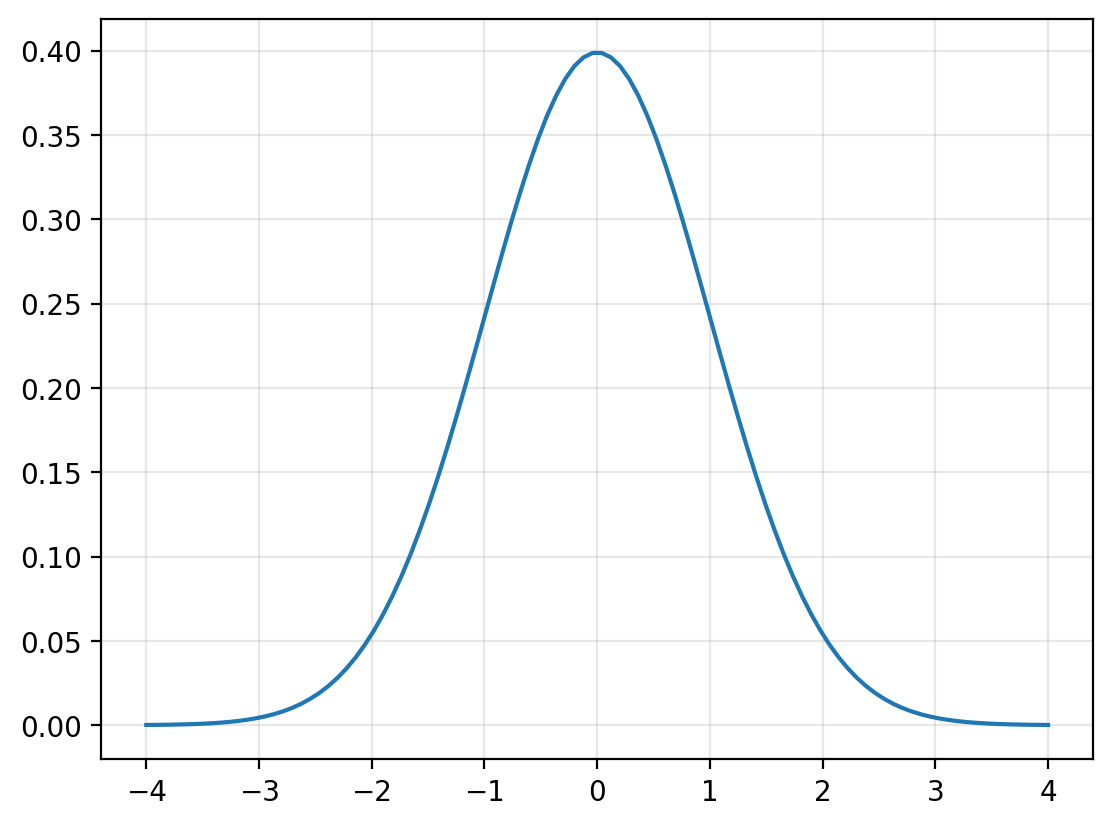

In [901]:
params = bocd.GaussParams.from_org(mean=0, variance=1.0)
px = bocd.ExpfamGaussConj(variance=1.0)

x = jnp.linspace(-4, 4, 100)
pdf_x = jax.vmap(px.pdf, (None, 0))(params, x)

plt.plot(x, pdf_x)
plt.grid(alpha=0.3)


In [898]:
params

GaussParams(chi=0.0, nu=1.0)

In [891]:
key = jax.random.PRNGKey(314)
x_obs = 5.0 + jax.random.normal(key, (100,))

In [892]:
params_update = params
for xn in x_obs:
    # params_update = params_update + jnp.array([xn, -1 / 2])
    params_update = px.update_params(params_update, xn)

In [ ]:
px.

In [893]:
params_update

GaussParams(chi=Array([495.56], dtype=float32), nu=101.0)

In [899]:
params

GaussParams(chi=0.0, nu=1.0)

In [1074]:
params = bocd.GaussParams.from_org(mean=0, variance=1.0)
state = bocd.init_bocd_state(T, params)
state

BOCPDState(T=10, params_expfam=Array([[0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32), log_evidence=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), log_joint=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), time=0)

In [1126]:
# Params run-length
t = 0
params_rl = state.params_expfam[0]
px.log_pdf(bocd.GaussParams.from_array(params_rl), x[0])

p_gauss = bocd.GaussParams.from_array(state.params_expfam[t])

In [1136]:
log_joint = jnp.zeros((T, T))

In [1137]:
t = 1

In [1138]:
log_joint[l] + pred_l + H_up

Array([-9.2756, -9.2756, -9.2756, -9.2756, -9.2756, -9.2756, -9.2756, -9.2756, -9.2756, -9.2756], dtype=float32)

In [1139]:
log_p_down = 0
for l in range(t):
    pred_l = px.log_pdf(p_gauss, x[l])
    
    H_up = bocd.log_prob_transition(l+1, l)
    log_p_up = log_joint[t, l] + pred_l + H_up
    log_joint = log_joint.at[t, l+1].set(log_p_up.squeeze())
    
    H_down = bocd.log_prob_transition(0, l)
    log_p_down = log_p_down + log_joint[t, l] + pred_l + H_down
    
log_joint = log_joint.at[t, 0].set(log_p_down.squeeze())


In [1140]:
log_joint

Array([[  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-10.1229,  -9.2756,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,  

In [1005]:
t = 1
jnp.exp(log_joint[t, :t+1] - jax.nn.logsumexp(log_joint[t, :t+1]))

Array([0.3, 0.7], dtype=float32)